In [15]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
image = cv2.imread('D:\ANPR\croped_num_plate\croped_num_plate\4T.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Original Image')
plt.show()

error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


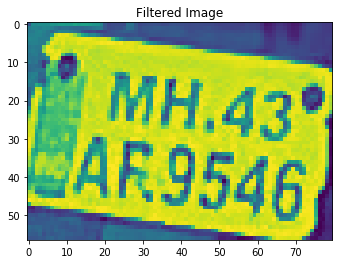

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
kernel = np.ones((5, 5), np.float32) / 15
#filtered = cv2.filter2D(gray, -1, kernel)
plt.imshow(gray)
plt.title('Filtered Image')
plt.show()

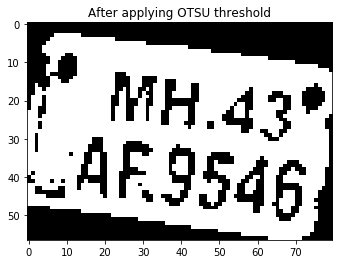

In [4]:
 """
    Apply OTSU threshold
    Args:
        filtered: np.array
    Returns:
        thresh: np.array
    """

ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.title('After applying OTSU threshold')
plt.show()

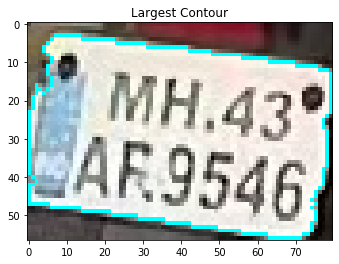

In [5]:
 """
    Args:
        img: np.array()
        image_shape: tuple
    Returns:
        canvas: np.array()
        cnt: list
    """
#image_shape = tuple
#canvas = np.zeros(image_shape, np.uint8)
image_copy = image.copy()
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
cv2.drawContours(image_copy, cnt, -1, (0, 255, 255), 1)
plt.title('Largest Contour')
plt.imshow(image_copy)
plt.show()

In [6]:
epsilon = 0.1 * cv2.arcLength(cnt, True) #2% of the contour arc length
approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
cv2.drawContours(image_copy, approx_corners, -1, (255, 255, 0), 5)
approx_corners = sorted(np.concatenate(approx_corners).tolist())
print('\nThe corner points are ...\n')
for index, c in enumerate(approx_corners):
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(image_copy, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)


The corner points are ...

A : [0, 47]
B : [4, 6]
C : [74, 54]
D : [78, 12]


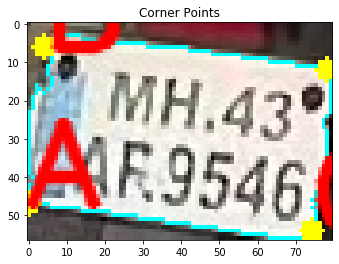

In [7]:
approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]
plt.imshow(image_copy)
plt.title('Corner Points')
plt.show()

In [8]:
w1 = np.sqrt((approx_corners[0][0] - approx_corners[1][0]) ** 2 + (approx_corners[0][1] - approx_corners[1][1]) ** 2)
w2 = np.sqrt((approx_corners[2][0] - approx_corners[3][0]) ** 2 + (approx_corners[2][1] - approx_corners[3][1]) ** 2)
w = max(int(w1), int(w2))

h1 = np.sqrt((approx_corners[0][0] - approx_corners[2][0]) ** 2 + (approx_corners[0][1] - approx_corners[2][1]) ** 2)
h2 = np.sqrt((approx_corners[1][0] - approx_corners[3][0]) ** 2 + (approx_corners[1][1] - approx_corners[3][1]) ** 2)
h = max(int(h1), int(h2))

destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
#destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
        
print('\nThe destination points are: \n')
for index, c in enumerate(destination_corners):
    character = chr(65 + index) + "'"
    print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))


The destination points are: 

A' : [0. 0.]

The approximated height and width of the original image is: 
 (42, 74)
B' : [73.  0.]

The approximated height and width of the original image is: 
 (42, 74)
C' : [ 0. 41.]

The approximated height and width of the original image is: 
 (42, 74)
D' : [73. 41.]

The approximated height and width of the original image is: 
 (42, 74)



The homography matrix is: 
 [[ 1.00406571e+00  9.79576305e-02 -4.60400863e+00]
 [ 9.38855476e-02 -9.92504361e-01  4.66477050e+01]
 [ 3.22049959e-04  6.26210759e-05  1.00000000e+00]]


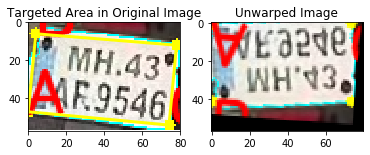

In [9]:
    h, w = image_copy.shape[:2]
    H, _ = cv2.findHomography(np.float32(approx_corners), destination_corners, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    print('\nThe homography matrix is: \n', H)
    un_warped = cv2.warpPerspective(image_copy, H, (w, h), flags=cv2.INTER_LINEAR)

    # plot

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_copy)
    x = [approx_corners[0][0], approx_corners[2][0], approx_corners[3][0], approx_corners[1][0], approx_corners[0][0]]
    y = [approx_corners[0][1], approx_corners[2][1], approx_corners[3][1], approx_corners[1][1], approx_corners[0][1]]
    ax1.plot(x, y, color='yellow', linewidth=3)
    ax1.set_ylim([h, 0])
    ax1.set_xlim([0, w])
    ax1.set_title('Targeted Area in Original Image')
    ax2.imshow(un_warped)
    ax2.set_title('Unwarped Image')
    plt.show()

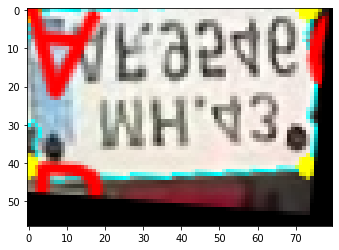

In [11]:
cropped = un_warped[0:h, 0:w]
plt.imshow(cropped)
plt.show()

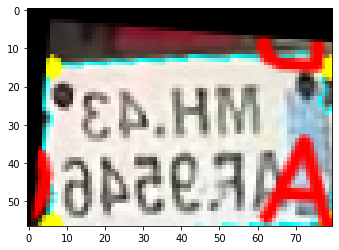

In [12]:
cropped = cv2.flip(cropped, -1)
plt.imshow(cropped)
plt.show()

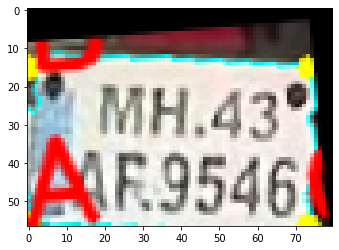

In [13]:
cropped = cv2.flip(cropped, 1)
plt.imshow(cropped)
plt.show()